<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Сколько-нужно-наблюдений" data-toc-modified-id="Сколько-нужно-наблюдений-2">Сколько нужно наблюдений</a></span><ul class="toc-item"><li><span><a href="#Гипотеза-о-кнопке" data-toc-modified-id="Гипотеза-о-кнопке-2.1">Гипотеза о кнопке</a></span></li><li><span><a href="#Другие-тесты" data-toc-modified-id="Другие-тесты-2.2">Другие тесты</a></span></li><li><span><a href="#Кривые-мощности" data-toc-modified-id="Кривые-мощности-2.3">Кривые мощности</a></span></li></ul></li><li><span><a href="#Бутстрап" data-toc-modified-id="Бутстрап-3">Бутстрап</a></span><ul class="toc-item"><li><span><a href="#Д.И.-для-среднего-(пример-про-копилку)" data-toc-modified-id="Д.И.-для-среднего-(пример-про-копилку)-3.1">Д.И. для среднего (пример про копилку)</a></span><ul class="toc-item"><li><span><a href="#Д.И.-Эфрона" data-toc-modified-id="Д.И.-Эфрона-3.1.1">Д.И. Эфрона</a></span></li><li><span><a href="#Д.И.-Холла" data-toc-modified-id="Д.И.-Холла-3.1.2">Д.И. Холла</a></span></li><li><span><a href="#t-процентильный-Д.И." data-toc-modified-id="t-процентильный-Д.И.-3.1.3">t-процентильный Д.И.</a></span></li></ul></li></ul></li></ul></div>

#  Сколько нужно наблюдений

Посмотрим на то, как для конкретных критериев можно расчитывать число наблюдений питоновскими средствами. 

## Гипотеза о кнопке

Посмотрим на пример с долями. У нас есть две кнопки: старая и новая. Мы хотим проверить гипотезу о том, что доля нажатий по обеим кнопкам совпадает. В качестве альтернативы рассматриваем вариант, что новый дизайн кнопки оказался лучше и нажать на неё хочется больше.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_0 = p_a \\
&H_1: \hspace{2mm} p_0 < p_a  
\end{aligned}
$$

Величины $p_0$ и $p_a$ мы оцениваем, как отношение кликов на кнопку к показам в контрольной группе и в тестовой группе. Число наблюдений, которое нам необходимо, в таком случае, можно найти по формуле: 

$$
n = \left( \frac{\sqrt{p_0 \cdot (1 - p_0) } \cdot z_{1 - \alpha} + \sqrt{p_a \cdot (1 - p_a) } \cdot z_{1 - \beta} }{p_a - p_0}  \right)^2,
$$

где $n$ - число наблюдений, $\alpha$ - ошибка первого рода, $\beta$ - ошибка второго рода, $z_{1 - \alpha}, z_{1 - \beta}$ - квантили нормального распределения. 


In [2]:
def get_size(p0, pa, alpha, beta):
    za = stats.norm.ppf(1 - alpha)
    zb = stats.norm.ppf(1 - beta)    
    n = za * np.sqrt(p0 * (1 - p0)) + zb * np.sqrt(pa * (1 - pa))
    n /= (pa - p0)
    return int(np.ceil(n*n))

In [3]:
alpha = 0.05
beta = 0.05

In [4]:
# сколько наблюдений надо, чтобы получить ошибки alpha и beta и уловить минимальный эффект pa - p0
get_size(0.10, 0.15, alpha, beta) 

468

Теперь посчитаем тоже самое с помощью пакета `statsmodels`. Внутри него есть функция `zt_ind_solve_power`. Она может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной пишется `None`. 

Обратите внимание, что в качестве размера эффекта в функцию подаётся стандартизированный эффект, а не оригинальный (отнормированный на стандартное отклонение)

$$
effect = \frac{p_0 - p_a}{se},
$$

при этом стандартная ошибка считается как 

$$
se = \sqrt{\frac{(n_1 - 1)\cdot s_1^2 + (n_2 - 1) \cdot s_2^2 }{n_1 + n_2 - 2}}.
$$

In [5]:
n_0, n_a = 468, 468   # размеры выборок
p_0, p_a = 0.1, 0.15  # доли 

# дисперсии
var_0 = p_0 * (1 - p_0)
var_a = p_a * (1 - p_a)

# стандартизированный размер эффекта
standartized_effect = \
    (p_a - p_0) / \
    np.sqrt(( (n_0-1) * var_0 + (n_a-1) * var_a) / (n_0 + n_a - 2))

standartized_effect

0.15161960871578062

In [6]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

# параметр ratio отвечает за то в какой из двух выборок больше наблюдений
sample_size = zt_ind_solve_power(
                    effect_size = standartized_effect,  # стандартизованный размер эффекта
                    nobs1 = None,           # число наблюдений None, тк их хотим найти 
                    alpha = alpha,          # уровень значимости 
                    power = (1 - beta),     # мощность
                    ratio = 1,              # перекос в выборках, если 0, тогда выборка только одна
                    alternative = 'larger'  # альтернатива
                )

print(sample_size) # у нас две выборки, на каждую поровну

941.5291210637375


Подставив `None` вместо другого аргумента функции, можем рассчитать что-нибудь ещё. Например, мощность теста.

In [7]:
zt_ind_solve_power(effect_size = 0.15219, 
                   nobs1 = 941, 
                   alpha = alpha,
                   power = None, 
                   ratio = 1,
                   alternative = 'larger')

0.9511696099123256

Или размер эффекта. 

In [8]:
zt_ind_solve_power(effect_size = None, 
                   nobs1 = 2 * 467, 
                   alpha = alpha, 
                   power = 1 - beta, 
                   ratio = 1, 
                   alternative = 'larger')

0.1522295561785361

По аналогии можно работать с любой асимптотически нормальной статистикой. 

## Другие тесты

По аналогии реализованы [многие другие тесты.](https://www.statsmodels.org/stable/stats.html) Например, тест Стьюдента. Рассмотрим тест для равенства средних при неизвестных, но равных дисперсиях. 

Класс `TTestIndPower` предназначен для анализа мощности для t-теста Стьюдента с независимыми выборками (`TTestPower` для обычного либо с зависимыми выборками).

У каждого объекта этого класса есть метод `solve_power`. Он может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной ствится `None`. 

Снова в качестве эффекта на вход идёт стандартизованный эффект: 

$$
effect = \frac{\bar{x_1} - \bar{x_2}}{se},
$$


In [9]:
from statsmodels.stats.power import TTestIndPower

effect = 0.5
alpha = 0.05
power = 0.95

analysis = TTestIndPower()
analysis.solve_power(effect, 
                     nobs1 = None, 
                     power = power, 
                     alpha = alpha, 
                     ratio = 1)

104.9279466344438

## Кривые мощности

Построим для мощностей кривые. Они будут показывать размер эффекта и размер выборки влияют на мощность теста. 

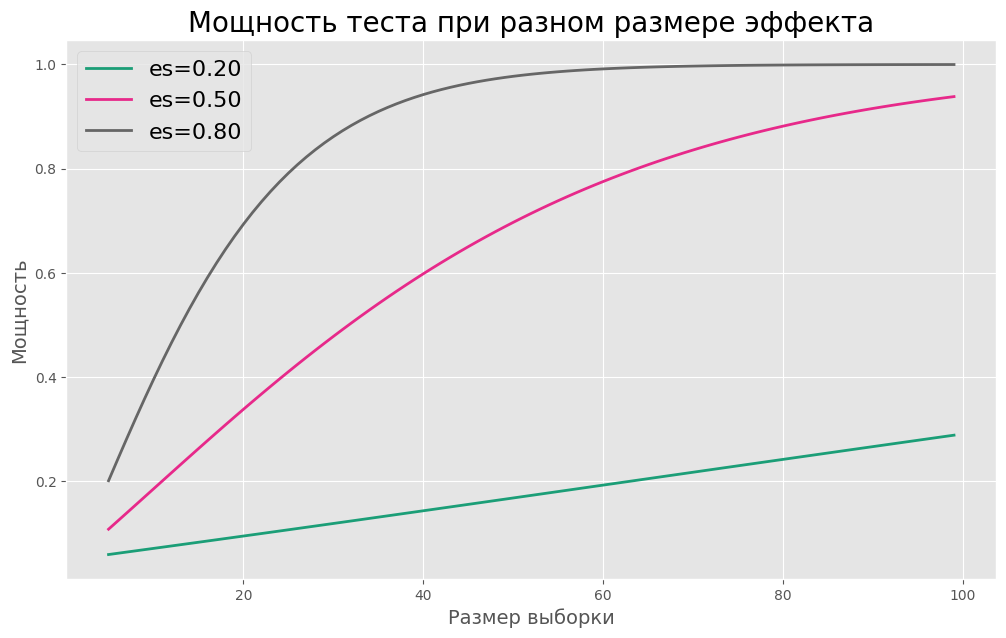

In [10]:
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))

analysis = TTestIndPower()

_, axes = plt.subplots(1, 1, figsize=(12,7))

analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes, 
    effect_size=effect_sizes,
    ax=axes
)

axes.set_title("Мощность теста при разном размере эффекта", fontsize = 20)
axes.set_xlabel("Размер выборки", fontsize = 14)
axes.set_ylabel("Мощность", fontsize = 14)
plt.legend(fontsize = 16);

На графике мы видим как меняется мощность критерия при трёх разных размерах эффекта. Если нас интересует большой эффект, то мы выходим к единице при примерно $60$ наблюдениях.

# Бутстрап

В этой тетрадке речь пойдёт про бустрап.

* [Статья про бустрэп от Станислава Анатольева](http://quantile.ru/03/03-SA.pdf)
* [Неплохая статья про бутстрап в R, на основе которой делалась тетрадка](https://moderndive.com/8-confidence-intervals.html)

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Д.И. для среднего (пример про копилку)



![](https://d33wubrfki0l68.cloudfront.net/fe3d13cf8652057fd5ea97fc4d7db1f00b2b1f34/62975/images/sampling/pennies/deliverable/3.jpg)

Представим, что завели себе копилку и собираем десятирублёвые монеты. Интересно как именно распределён возраст этих монет.

Сделали из копилки случайную выборку из сотни десятирублёвых монет и записали дату с каждой в файл `money.csv`.

In [12]:
x = pd.read_csv('./money.csv').fielddate.values
x

array([2011, 2017, 2016, 2012, 2017, 2015, 2011, 2015, 2017, 2012, 2019,
       2019, 2012, 2018, 2018, 2018, 2018, 2017, 2018, 2012, 2010, 2012,
       2012, 2011, 2011, 2012, 2011, 2017, 2017, 2016, 2012, 2012, 2017,
       2017, 2012, 2010, 2018, 2016, 2011, 2017, 2012, 2017, 2013, 2017,
       2010, 2011, 2018, 2015, 2011, 2018, 2012, 2013, 2009, 2017, 2017,
       2018, 2019, 2018, 2011, 2013, 2011, 2013, 2017, 2018, 2011, 2012,
       2018, 2012, 2019, 2018, 2011, 2017, 2019, 2019, 2019, 2012, 2011,
       2013, 2011, 2017, 2013, 2013, 2017, 2017, 2017, 2011, 2019, 2013,
       2017, 2012, 2009, 2010, 2010, 2020, 2019, 2020, 2020, 2019, 2018,
       2020])

In [13]:
x = 2025 - x # перешли к возрасту
x

array([14,  8,  9, 13,  8, 10, 14, 10,  8, 13,  6,  6, 13,  7,  7,  7,  7,
        8,  7, 13, 15, 13, 13, 14, 14, 13, 14,  8,  8,  9, 13, 13,  8,  8,
       13, 15,  7,  9, 14,  8, 13,  8, 12,  8, 15, 14,  7, 10, 14,  7, 13,
       12, 16,  8,  8,  7,  6,  7, 14, 12, 14, 12,  8,  7, 14, 13,  7, 13,
        6,  7, 14,  8,  6,  6,  6, 13, 14, 12, 14,  8, 12, 12,  8,  8,  8,
       14,  6, 12,  8, 13, 16, 15, 15,  5,  6,  5,  5,  6,  7,  5])

Посмотрим как распределён возраст. 

In [14]:
x.shape

(100,)

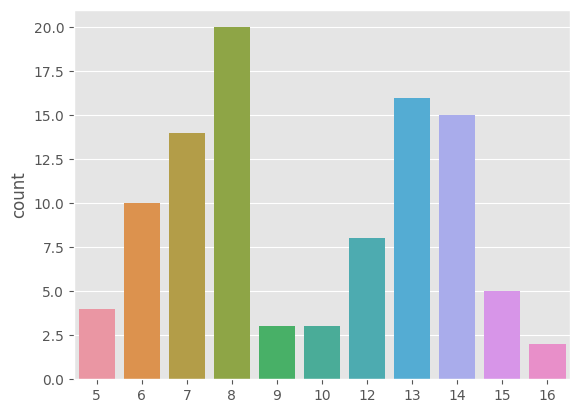

In [15]:
sns.countplot(x = x);

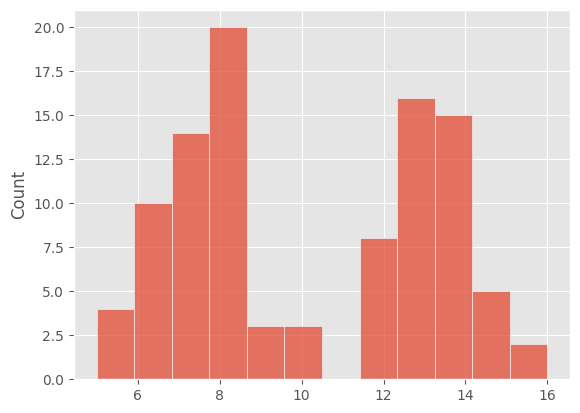

In [16]:
sns.histplot(x, bins = 12);

Распределение оказывается нестандартным. Видно, что у него есть две моды. Посмотрим на средний возраст монет.

In [17]:
x.mean()

10.16

In [18]:
np.median(x)

9.0

Интересно было бы построить для этого среднего доверительный интервал. Сделаем это с помощью бустрапа.

Напишем функцию для бустрапирования.

In [19]:
def get_bootstrap_sample(x, B_sample = 1):
    N = x.size
    sample = np.random.choice(x, size = (N, B_sample), replace = True)
    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [20]:
x

array([14,  8,  9, 13,  8, 10, 14, 10,  8, 13,  6,  6, 13,  7,  7,  7,  7,
        8,  7, 13, 15, 13, 13, 14, 14, 13, 14,  8,  8,  9, 13, 13,  8,  8,
       13, 15,  7,  9, 14,  8, 13,  8, 12,  8, 15, 14,  7, 10, 14,  7, 13,
       12, 16,  8,  8,  7,  6,  7, 14, 12, 14, 12,  8,  7, 14, 13,  7, 13,
        6,  7, 14,  8,  6,  6,  6, 13, 14, 12, 14,  8, 12, 12,  8,  8,  8,
       14,  6, 12,  8, 13, 16, 15, 15,  5,  6,  5,  5,  6,  7,  5])

In [21]:
x_boot = get_bootstrap_sample(x)
x_boot

array([ 8, 10, 13,  9, 13, 13, 10,  7,  8,  6,  8,  8, 15,  8,  5, 14, 14,
        7, 12,  7,  6,  7, 14, 12, 13,  8, 15, 14, 14, 10,  7, 13,  8,  6,
       12,  8,  5,  7,  5,  8, 13, 12,  7,  8,  6, 13, 14,  6,  7,  6, 13,
       14,  7, 14, 12, 13,  7, 14,  9, 15,  8,  6, 14,  9,  8,  8, 13, 12,
        6, 14,  8, 13,  8,  8,  7,  8, 15,  7,  6, 15,  8, 12, 12,  7,  6,
       13,  5,  7, 13, 12,  8, 12, 14, 12,  6, 10,  7, 14,  6,  8])

Давайте сравним распределение выборки, которую мы сэмплировали с исходной.

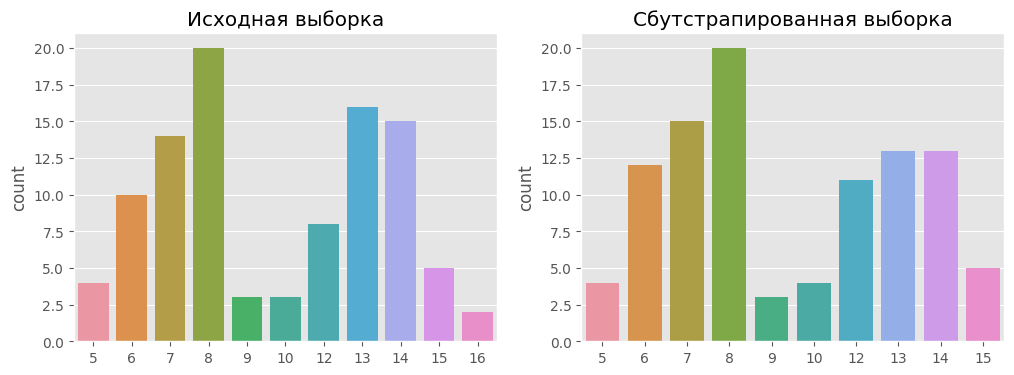

In [22]:
_, axes = plt.subplots(1, 2, figsize = (12,4))

sns.countplot(x = x, ax = axes[0])
sns.countplot(x = x_boot, ax = axes[1])
axes[0].set_title("Исходная выборка")
axes[1].set_title("Сбутстрапированная выборка");

Сгенерируем выборку из средних.

In [23]:
# генерируем 1 миллион выборок размера 100
x_boot = get_bootstrap_sample(x, B_sample = 10**6)
x_boot.shape

(100, 1000000)

In [24]:
x_boot

array([[12,  8, 13, ...,  7, 14,  6],
       [ 8,  8, 14, ..., 14,  6,  8],
       [ 5,  5, 12, ...,  8, 13,  9],
       ...,
       [ 7, 13, 13, ..., 14, 14,  6],
       [13,  8,  7, ..., 14,  8,  8],
       [ 7, 14, 10, ...,  7,  6,  7]])

In [25]:
x_boot_m = np.mean(x_boot, axis = 0)
x_boot_m

array([10.31,  9.73, 10.26, ...,  9.92, 10.75, 10.26])

In [26]:
x_boot_m.shape

(1000000,)

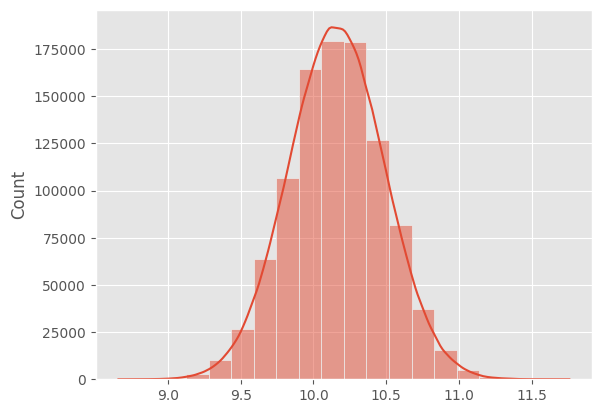

In [27]:
sns.histplot(x_boot_m, bins = 20, kde = True);

Сравним получившееся распределение с нормальным. Они оказываются похожи. Это связано с тем, что мы бустрапируем среднее, в возрасте монет нет выбросов, поэтому тут хорошо работает ЦПТ. 

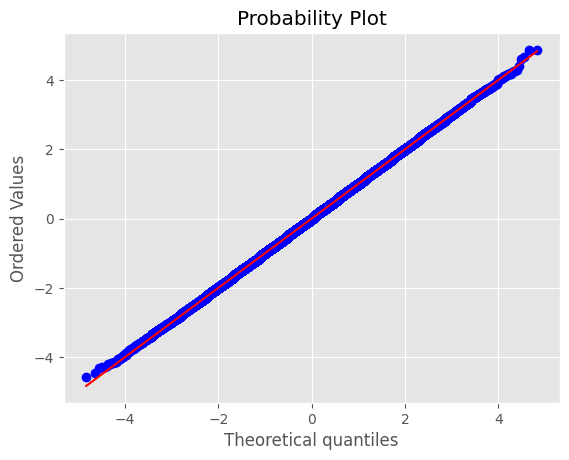

In [28]:
x_scale = (x_boot_m - x_boot_m.mean()) / x_boot_m.std()
stats.probplot(x_scale, dist = "norm", plot = plt);

### Д.И. Эфрона

Построим доверительный интервал для среднего. 

In [29]:
alpha = 0.05

# посчитали 1 миллион средних по каждой из бутстраппированных выборок
x_boot_m = np.mean(x_boot, axis = 0)

lower = np.quantile(x_boot_m, alpha / 2)
upper = np.quantile(x_boot_m, 1-alpha / 2)
lower, upper

(9.52, 10.8)

In [30]:
upper-lower

1.2800000000000011

In [31]:
d = 1.96*(x.var(ddof=1)/x.size)**0.5
x.mean() - d, x.mean() + d

(9.512801163677365, 10.807198836322636)

In [32]:
2*d

1.2943976726452715

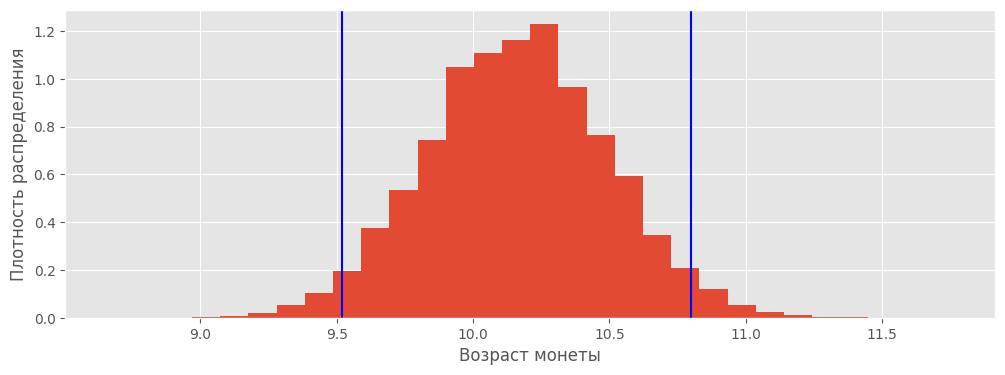

In [33]:
fig = plt.figure(figsize=(12,4))
plt.hist(x_boot_m, bins=30, density=True)
plt.axvline(lower, color='b')
plt.axvline(upper, color='b');

plt.xlabel('Возраст монеты')
plt.ylabel('Плотность распределения');

### Д.И. Холла

In [34]:
alpha = 0.05

# сначала фиксируем глобальное среднее по всей выборке
theta_hat = np.mean(x)

x_boot = get_bootstrap_sample(x, B_sample = 10**6)

# центрируем с помощью глобального среднего
x_boot_centered = x_boot - theta_hat

# снова считаем статистику по центрированным бутстраппированным выборкам
bias_boot = np.mean(x_boot_centered, axis = 0)


# считаем квантили и вычитаем/прибавляем от глобальгого среднего
lower = theta_hat - np.abs(np.quantile(bias_boot, alpha/2))
upper = theta_hat + np.abs(np.quantile(bias_boot, 1-alpha/2))

lower, upper

(9.520000000000001, 10.81)

In [35]:
bias_boot.shape

(1000000,)

In [36]:
upper - lower

1.2899999999999991

###  t-процентильный Д.И.

In [37]:
# сначала фиксируем глобальное среднее и выборочную дисперсию по всей выборке
theta_hat = np.mean(x)
std_hat = np.std(x)

# делаем бутстрап-выборки
x_boot = get_bootstrap_sample(x, B_sample = 10**6)

# центрируем (вычитаем глобальное среднее)
x_boot_centered = x_boot - theta_hat
x_boot_t = np.mean(x_boot_centered, axis = 0)

# считаем ст. отклонение по каждой бутстрап-выборке
x_boot_std = np.std(x_boot, axis = 0)
# стандартизуем
x_boot_t /= x_boot_std


lower = theta_hat - np.abs(np.quantile(x_boot_t, alpha/2))*std_hat
upper = theta_hat + np.abs(np.quantile(x_boot_t, 1-alpha/2))*std_hat
lower, upper

(9.498739565614269, 10.811106910718)

In [38]:
upper - lower

1.3123673451037305

Последний доверительный интервал получился пошире. [Теория показывает,](http://quantile.ru/03/03-SA.pdf) что последний способ даёт более низкую ошибку в плане асимптотики. 